In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
import seaborn as sns
from datetime import datetime, timedelta

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

In [2]:
from lstm import LSTM
from preprocessing import *
from utils import *
from features import *

In [3]:
raw_data = pd.read_csv('consumption_and_temperatures.csv')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

In [4]:
raw_data

,timestamp,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature
0,2017-05-01 00:00:00+00:00,3325.431995,2.1,3534.588000,5.0,2674.838000,5.5,2061.209000,0.2,1609.089000,3.9
1,2017-05-01 01:00:00+00:00,3344.690998,1.8,3560.209000,4.1,2678.188000,4.0,2045.436000,0.1,1623.485000,3.2
2,2017-05-01 02:00:00+00:00,3398.359002,3.2,3596.149000,3.1,2678.341000,3.7,2020.007000,0.1,1634.128000,2.7
3,2017-05-01 03:00:00+00:00,3430.220001,3.6,3594.042000,2.3,2684.172000,3.2,2021.920000,0.1,1647.906000,2.3
4,2017-05-01 04:00:00+00:00,3606.750000,3.4,3665.091000,2.6,2733.345000,2.7,2045.913000,0.1,1679.176000,2.3
...,...,...,...,...,...,...,...,...,...,...,...
58459,2023-12-31 19:00:00+00:00,5608.067736,-4.7,4962.057148,4.1,3837.204332,-3.7,2806.182692,-6.5,2224.449164,6.3
58460,2023-12-31 20:00:00+00:00,5469.722792,-4.6,4864.162484,4.7,3773.021260,-3.6,2764.928700,-6.4,2175.957992,6.3
58461,2023-12-31 21:00:00+00:00,5321.221040,-4.5,4793.361440,4.6,3725.022064,-4.2,2738.213476,-6.4,2137.724404,6.2
58462,2023-12-31 22:00:00+00:00,5222.770756,-4.5,4742.807424,4.6,3668.956000,-4.2,2699.056760,-6.5,2110.928436,5.7


In [5]:
data_shifted = raw_data.copy()
data_shifted['NO1_temperature_t-1'] = data_shifted['NO1_temperature'].shift(1)

In [6]:
data_shifted

,timestamp,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature,NO1_temperature_t-1
0,2017-05-01 00:00:00+00:00,3325.431995,2.1,3534.588000,5.0,2674.838000,5.5,2061.209000,0.2,1609.089000,3.9,NaN
1,2017-05-01 01:00:00+00:00,3344.690998,1.8,3560.209000,4.1,2678.188000,4.0,2045.436000,0.1,1623.485000,3.2,2.1
2,2017-05-01 02:00:00+00:00,3398.359002,3.2,3596.149000,3.1,2678.341000,3.7,2020.007000,0.1,1634.128000,2.7,1.8
3,2017-05-01 03:00:00+00:00,3430.220001,3.6,3594.042000,2.3,2684.172000,3.2,2021.920000,0.1,1647.906000,2.3,3.2
4,2017-05-01 04:00:00+00:00,3606.750000,3.4,3665.091000,2.6,2733.345000,2.7,2045.913000,0.1,1679.176000,2.3,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...
58459,2023-12-31 19:00:00+00:00,5608.067736,-4.7,4962.057148,4.1,3837.204332,-3.7,2806.182692,-6.5,2224.449164,6.3,-4.7
58460,2023-12-31 20:00:00+00:00,5469.722792,-4.6,4864.162484,4.7,3773.021260,-3.6,2764.928700,-6.4,2175.957992,6.3,-4.7
58461,2023-12-31 21:00:00+00:00,5321.221040,-4.5,4793.361440,4.6,3725.022064,-4.2,2738.213476,-6.4,2137.724404,6.2,-4.6
58462,2023-12-31 22:00:00+00:00,5222.770756,-4.5,4742.807424,4.6,3668.956000,-4.2,2699.056760,-6.5,2110.928436,5.7,-4.5


In [7]:
seq_len = 72
scale_output=True
features_to_add=[(add_season_columns, {}), (pick_location_data, {'loc': [1]})]

In [8]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (scalerInputMethod, scalerOutputMethod), (target_axis_x, target) = general_preprocessing(
    raw_data, 
    features_to_add=features_to_add,
    seq_len=seq_len,
    forecast_len=24,
    test_start_index=3 * len(raw_data) // 4,
    scale_output=scale_output
    )

FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [9]:
43776 == 3 * len(raw_data) // 4, 3 * len(raw_data) // 4 - 43776

(False, 72)

In [10]:
raw_data[43776:]

,timestamp,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature
43776,2022-04-29 00:00:00+00:00,3013.492067,6.4,3615.296941,5.7,3105.267791,0.5,2271.111525,-3.8,1582.885382,6.9
43777,2022-04-29 01:00:00+00:00,3019.167135,5.5,3618.892866,5.0,3107.300761,0.6,2300.348632,-3.3,1557.749586,6.6
43778,2022-04-29 02:00:00+00:00,3066.283324,5.0,3653.847960,3.3,3115.326680,1.3,2298.961351,-3.7,1561.116235,6.6
43779,2022-04-29 03:00:00+00:00,3167.085943,4.8,3743.718010,2.8,3084.318628,1.3,2294.753633,-3.8,1582.091229,6.6
43780,2022-04-29 04:00:00+00:00,3531.231895,4.8,3984.479089,2.3,3227.162118,1.8,2379.613315,-3.0,1664.296855,6.2
...,...,...,...,...,...,...,...,...,...,...,...
58459,2023-12-31 19:00:00+00:00,5608.067736,-4.7,4962.057148,4.1,3837.204332,-3.7,2806.182692,-6.5,2224.449164,6.3
58460,2023-12-31 20:00:00+00:00,5469.722792,-4.6,4864.162484,4.7,3773.021260,-3.6,2764.928700,-6.4,2175.957992,6.3
58461,2023-12-31 21:00:00+00:00,5321.221040,-4.5,4793.361440,4.6,3725.022064,-4.2,2738.213476,-6.4,2137.724404,6.2
58462,2023-12-31 22:00:00+00:00,5222.770756,-4.5,4742.807424,4.6,3668.956000,-4.2,2699.056760,-6.5,2110.928436,5.7


In [11]:
3 * len(raw_data) // 4

43848

In [12]:
X_train.mean(), X_test.mean(), X_val.mean()

(tensor(0.1999), tensor(0.2344), tensor(0.1622))

In [13]:
scalerInputMethod.mean_

array([7.7647089])

In [14]:
input_size = X_train.shape[2]
hidden_size = 11
num_layers = 3

In [15]:
path = "models/LSTM-2024-03-13-loss-0.114071354"

In [16]:
# model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
# model.load_state_dict(torch.load(path))
# model.eval()

In [17]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

In [18]:
num_epochs = 300
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
# losses = []
# val_loss = []
# for epoch in tqdm(range(num_epochs)):
#     model.train()
#     outputs = model(X_train)

#     loss_ep = loss_func(outputs, y_train)

#     losses.append(loss_ep.detach().numpy())
#     opt.zero_grad()
#     loss_ep.backward()
#     opt.step()

#     model.eval()
#     val_loss.append(loss_func(model(X_val), y_val))

In [20]:
model, losses, val_loss, opt = fit(
    model, 
    train_set=(X_train, y_train),
    val_set=(X_val, y_val),
    opt=opt,
    loss_func=loss_func,
    num_epochs=num_epochs)

100%|██████████| 300/300 [19:25<00:00,  3.88s/it]


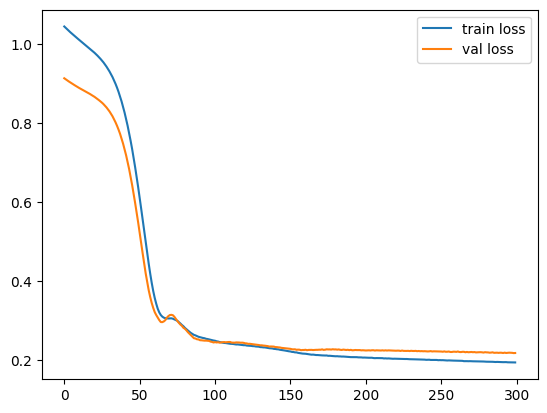

In [21]:
plt.plot(losses, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()

In [22]:
model.eval()

y_pred = model(X_test).detach().numpy()

In [23]:
y_test.shape, y_pred.shape

(torch.Size([24, 72, 1]), (24, 72, 1))

In [24]:
forecast = y_pred[:,-1,:]
x_ax_forecast = x_ax_target[seq_len-1:]

In [25]:
df_forecast = pd.DataFrame({
    'timestamp': x_ax_forecast['timestamp'].values, 
    'consumption_forecast': scalerOutputMethod.inverse_transform(forecast).reshape(-1) if scale_output else forecast.reshape(-1)
    })

In [26]:
df_forecast.index = x_ax_forecast.index

In [27]:
target_column = 'NO1_consumption'

In [28]:
df_result = x_ax_target
df_result[target_column] = raw_data[target_column][x_ax_target.index[0]:x_ax_target.index[-1]+1]
df_result['forecast'] = df_forecast['consumption_forecast']

In [29]:
r_target = scalerOutputMethod.inverse_transform(target).reshape(-1) if scale_output else target
r_forecast = scalerOutputMethod.inverse_transform(forecast).reshape(-1) if scale_output else forecast

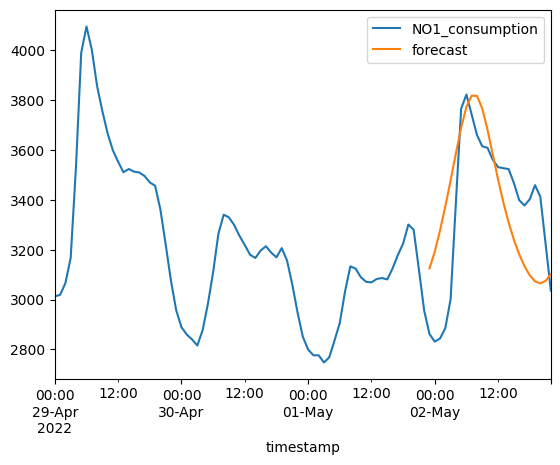

In [30]:
df_result.set_index('timestamp').plot()
plt.legend()
plt.show()

In [31]:
x_ax_target

,timestamp,NO1_consumption,forecast
43776,2022-04-29 00:00:00+00:00,3013.492067,NaN
43777,2022-04-29 01:00:00+00:00,3019.167135,NaN
43778,2022-04-29 02:00:00+00:00,3066.283324,NaN
43779,2022-04-29 03:00:00+00:00,3167.085943,NaN
43780,2022-04-29 04:00:00+00:00,3531.231895,NaN
...,...,...,...
43866,2022-05-02 18:00:00+00:00,3402.604031,3097.618652
43867,2022-05-02 19:00:00+00:00,3459.443829,3073.446289
43868,2022-05-02 20:00:00+00:00,3413.622136,3065.303467
43869,2022-05-02 21:00:00+00:00,3225.223978,3075.175293


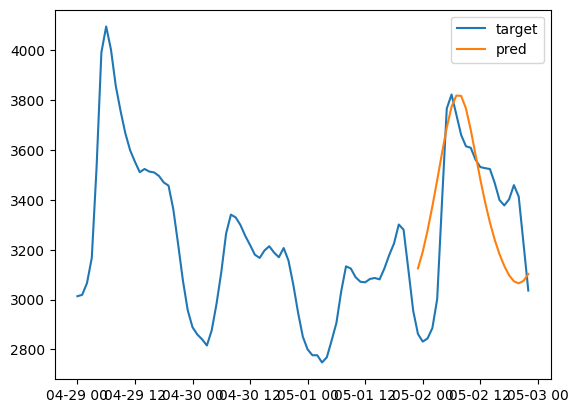

In [32]:
plt.plot(x_ax_target['timestamp'], r_target, label="target")
plt.plot(x_ax_forecast['timestamp'], r_forecast, label='pred')
plt.legend()

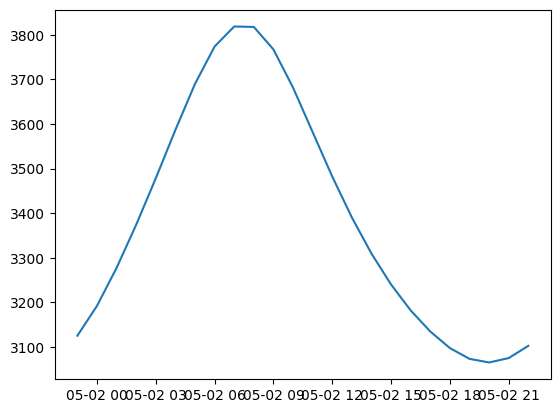

In [33]:
# plt.plot(x_ax_target, scalerOutputMethod.inverse_transform(target).reshape(-1), label="target")
plt.plot(x_ax_forecast, scalerOutputMethod.inverse_transform(forecast.reshape(-1, 1)).reshape(-1), label='pred')

In [34]:
forecast.shape

(24, 1)

In [35]:
y_pred.shape, y_test.shape

((24, 72, 1), torch.Size([24, 72, 1]))

In [36]:
hours_values = []

len_forecast = len(y_pred)
for h in range(len_forecast).reverse():

    hour_values = y_pred[:,seq_len-h,:]
    hours_values.append(hour_values)
    
    average = datasets.mean(axis=0)
    std_dev = datasets.std(axis=0)

plt.errorbar(x_ax_forecast['timestamp'], average, yerr=std_dev)

AttributeError: 'range' object has no attribute 'reverse'